In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [2]:
from statsmodels.tsa.statespace.varmax import VARMAX
from Modelling import modelling
import matplotlib.pyplot as plt
from DataPrep.ImportData import importer
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pyforest
import warnings
warnings.filterwarnings("ignore")

In [454]:
df = importer().Import()

In [4]:
def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [432]:
df2 = df.set_index("Start Date", drop=False)
df2.index = df2.index.to_period("D")

In [488]:
df2

,Label,Charging Time (mins),Energy (kWh),Total Duration (mins),Port Number,CenterLon,CenterLat,Level 1,Level 2,# Professional & Other Places,...,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend,Start Date
2011-07-29,0.0,114.050000,1.562364,183.533333,4.0,-122.160000,37.445,0,2,309,...,0,1,0,0,0,0,0,0,0,2011-07-29
2011-07-29,3.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,2011-07-29
2011-07-29,4.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,2011-07-29
2011-07-29,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,2011-07-29
2011-07-29,7.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0,0,0,...,0,0,0,0,0,0,0,0,0,2011-07-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,2.0,1264.087011,2.623270,1525.839425,36.0,-122.162000,37.447,0,20,278,...,0,0,0,0,0,0,1,0,0,2019-12-31
2019-12-31,1.0,1264.066667,3.819531,1380.133333,32.0,-122.163000,37.443,0,20,266,...,0,0,0,0,0,0,1,0,0,2019-12-31
2019-12-31,0.0,1654.579917,3.441929,2168.573706,41.0,-122.160000,37.444,0,25,309,...,0,0,0,0,0,0,1,0,0,2019-12-31
2019-12-31,6.0,618.500000,2.015957,650.383333,23.0,-122.146000,37.426,0,15,259,...,0,0,0,0,0,0,1,0,0,2019-12-31


In [455]:
df2 = pd.DataFrame()

<IPython.core.display.Javascript object>

In [456]:
df = df.set_index("Start Date")
df.index = df.index.to_period("D")

In [458]:
idx = pd.period_range(df.index.min(),df.index.max())
for i in range(8): 
    dat = df[df["Label"]==float(i)].reindex(idx, fill_value=0)
    dat.Label = float(i)
    df2 = df2.append(dat)


<IPython.core.display.Javascript object>

In [466]:
df2 = df2.sort_index()
df2["Start Date"] = df2.index


In [498]:
int(df2[df2["Label"]==0.0].shape[0]*0.2)

615

In [536]:
y = df2[["Energy (kWh)","Start Date"]]

idx_train = int(df2[df2["Label"]==0.0].shape[0]*0.8*0.9)*8
idx_val = int(df2[df2["Label"]==0.0].shape[0]*0.8*0.1)*8
idx_test = (int(df2[df2["Label"]==0.0].shape[0]*0.2)+1)*8

#y= y.resample("d").min()
X = lags().buildLaggedFeatures(df2[["Energy (kWh)","Label"]], ["Energy (kWh)"],5, dropna=False)
X = X.drop(columns=["Energy (kWh)"])
X_train = X[0:idx_train].fillna(0)
X_val = X[idx_train:idx_train+idx_val].fillna(0)
X_test = X[idx_train+idx_val:idx_train+idx_val+idx_test].fillna(0)

y_train = y["Energy (kWh)"][0:idx_train]
y_val = y["Energy (kWh)"][idx_train:idx_train+idx_val]
y_test = y["Energy (kWh)"][idx_train+idx_val:idx_train+idx_val+idx_test]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=False)
#X_train=X_train.drop(columns="lag_0")
#X_test=X_test.drop(columns="lag_0")
#X_val=X_val.drop(columns="lag_0")


In [537]:
X_train

,Label,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,Energy (kWh)_lag5
2011-07-29,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-29,3.0,1.562364,0.000000,0.000000,0.000000,0.000000
2011-07-29,4.0,0.000000,1.562364,0.000000,0.000000,0.000000
2011-07-29,1.0,0.000000,0.000000,1.562364,0.000000,0.000000
2011-07-29,7.0,0.000000,0.000000,0.000000,1.562364,0.000000
...,...,...,...,...,...,...
2017-08-21,5.0,3.233870,2.280000,2.827500,2.996429,2.215360
2017-08-21,3.0,2.921962,3.233870,2.280000,2.827500,2.996429
2017-08-21,1.0,3.804053,2.921962,3.233870,2.280000,2.827500
2017-08-21,0.0,3.401296,3.804053,2.921962,3.233870,2.280000


In [441]:
#res = pd.DataFrame(index=df["Start Date"][0:int(len(day))-2])
res = pd.DataFrame(index = idx)
res = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
exog = pd.DataFrame(columns=["Lag 01","Lag 02","Lag 03","Lag 04","Lag 05","Lag 11","Lag 12","Lag 13","Lag 14","Lag 15","Lag 21","Lag 22","Lag 23","Lag 24","Lag 25","Lag 31","Lag 32","Lag 33","Lag 34","Lag 35","Lag 41","Lag 42","Lag 43","Lag 44","Lag 45","Lag 51","Lag 52","Lag 53","Lag 54","Lag 55","Lag 61","Lag 62","Lag 63","Lag 64","Lag 65","Lag 71","Lag 72","Lag 73","Lag 74","Lag 75"])
exog_train = []
for label in range(8):
    idx = pd.period_range(df2.index.min(),df2.index.max())
    dat = df2[df2["Label"]==float(label)].reindex(idx, fill_value=0)
    dat["Start Date"] = dat.index
    dat["Label"] = float(label)

    print(f"Label: {float(label)}")
    df1=df[df["Label"]==float(label)]
    df1=df1.sort_values("Start Date")
    #y = df1[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False)
    y = dat[["Energy (kWh)","Start Date"]]

    #y= y.resample("d").min()
    X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=False)
    X_train=X_train.drop(columns="lag_0")
    X_test=X_test.drop(columns="lag_0")
    X_val=X_val.drop(columns="lag_0")

    #y_train = y_train.set_index("Start Date",drop=False)
    #y_test = y_test.set_index("Start Date",drop=False)
    #y_val = y_val.set_index("Start Date",drop=False)

    #y_train.freq= "D"
    #y_val.freq= "D"
    #y_test.freq= "D"
    #y_train = y_train.resample("d").min()
    #y_test = y_test.resample("d").min()
    #y_val = y_val.resample("d").min()

    #X_train = X_train.resample("d").min()
    #X_test = X_test.resample("d").min()
    #X_val = X_val.resample("d").min()
   
    y_train["Energy (kWh)"]  = y_train["Energy (kWh)"].fillna(0)
    y_test["Energy (kWh)"]  = y_test["Energy (kWh)"].fillna(0)
    y_val["Energy (kWh)"]  = y_val["Energy (kWh)"].fillna(0)
    print(y_train)
    #idx_train = pd.date_range(start = df["Start Date"][0:int(len(day))-2].min(), end=df["Start Date"][0:int(len(day))-2].max(), freq="D")
    #idx_val = pd.date_range(start = y_val["Start Date"].min(), end=y_val["Start Date"].max(), freq="D")
    #idx_test = pd.date_range(start = y_test["Start Date"].min(), end=y_test["Start Date"].max(), freq="D")

    #if label==0:
        
        #y_train = y_train.append(pd.DataFrame({"Energy (kWh)":np.zeros(len(idx_train)-len(y_train["Energy (kWh)"])),"Start Date":idx_train[len(idx_train)-(len(idx_train)-len(y_train["Energy (kWh)"])):]}))
        #y_train = y_train.set_index("Start Date",drop=False)
        

        #y_val = y_val.append(pd.DataFrame({"Energy (kWh)":np.zeros(len(idx_val)),"Start Date":idx_val}))
        #y_val = y_val.set_index("Start Date",drop=False)


        #y_test = y_test.append(pd.DataFrame({"Energy (kWh)":np.zeros(len(idx_test)),"Start Date":idx_test}))
        #y_test = y_test.set_index("Start Date",drop=False)
    

        #X_train = X_train.append(pd.DataFrame({"Energy (kWh)":np.zeros(len(idx_train)),"Start Date":idx_train}))
        #exog = pd.DataFrame(index=df["Start Date"][0:int(len(day))-2])
        #X_val = X_val.append(pd.DataFrame({"Energy (kWh)":np.zeros(len(idx_val)),"Start Date":idx_val}))
        #X_test = X_test.append(pd.DataFrame({"Energy (kWh)":np.zeros(len(idx_test)),"Start Date":idx_test}))
    
    res[f"Label {label}"] = y_train["Energy (kWh)"]
    for i in range(1,6):
        exog[f"Lag {label}{i}"] = X_train[f"lag_{i}"].fillna(0)
exog_train.append(exog)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 0.0
            Energy (kWh)  Start Date
2011-07-29      1.562364  2011-07-29
2011-07-30      1.726841  2011-07-30
2011-07-31      2.325573  2011-07-31
2011-08-01      1.260311  2011-08-01
2011-08-02      2.098609  2011-08-02
...                  ...         ...
2017-08-16      2.471309  2017-08-16
2017-08-17      2.594241  2017-08-17
2017-08-18      2.326522  2017-08-18
2017-08-19      1.687359  2017-08-19
2017-08-20      2.272558  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 1.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      2.691587  2017-08-16
2017-08-17      2.836964  2017-08-17
2017-08-18      2.834679  2017-08-18
2017-08-19      3.113306  2017-08-19
2017-08-20      2.287367  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 2.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      2.257769  2017-08-16
2017-08-17      2.489758  2017-08-17
2017-08-18      2.533874  2017-08-18
2017-08-19      2.646528  2017-08-19
2017-08-20      2.736587  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 3.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      3.322226  2017-08-16
2017-08-17      4.255667  2017-08-17
2017-08-18      3.570545  2017-08-18
2017-08-19      4.211074  2017-08-19
2017-08-20      2.996429  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 4.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      1.707526  2017-08-16
2017-08-17      1.802300  2017-08-17
2017-08-18      2.272300  2017-08-18
2017-08-19      2.189803  2017-08-19
2017-08-20      2.215360  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 5.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      3.132630  2017-08-16
2017-08-17      2.451825  2017-08-17
2017-08-18      2.943384  2017-08-18
2017-08-19      1.922590  2017-08-19
2017-08-20      3.114628  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 6.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      2.321489  2017-08-16
2017-08-17      2.434056  2017-08-17
2017-08-18      2.158226  2017-08-18
2017-08-19      2.315737  2017-08-19
2017-08-20      2.024920  2017-08-20

[2215 rows x 2 columns]


<IPython.core.display.Javascript object>

Label: 7.0
            Energy (kWh)  Start Date
2011-07-29      0.000000  2011-07-29
2011-07-30      0.000000  2011-07-30
2011-07-31      0.000000  2011-07-31
2011-08-01      0.000000  2011-08-01
2011-08-02      0.000000  2011-08-02
...                  ...         ...
2017-08-16      2.296129  2017-08-16
2017-08-17      2.438667  2017-08-17
2017-08-18      5.232000  2017-08-18
2017-08-19      1.409333  2017-08-19
2017-08-20      1.907300  2017-08-20

[2215 rows x 2 columns]


In [561]:
X_train

,Label,Energy (kWh)_lag1,Energy (kWh)_lag2,Energy (kWh)_lag3,Energy (kWh)_lag4,Energy (kWh)_lag5
2011-07-29,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-29,3.0,1.562364,0.000000,0.000000,0.000000,0.000000
2011-07-29,4.0,0.000000,1.562364,0.000000,0.000000,0.000000
2011-07-29,1.0,0.000000,0.000000,1.562364,0.000000,0.000000
2011-07-29,7.0,0.000000,0.000000,0.000000,1.562364,0.000000
...,...,...,...,...,...,...
2017-08-21,5.0,3.233870,2.280000,2.827500,2.996429,2.215360
2017-08-21,3.0,2.921962,3.233870,2.280000,2.827500,2.996429
2017-08-21,1.0,3.804053,2.921962,3.233870,2.280000,2.827500
2017-08-21,0.0,3.401296,3.804053,2.921962,3.233870,2.280000


In [660]:
X_lags

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
2011-07-29,0.000000,NaN,NaN,NaN,NaN
2011-07-30,0.000000,NaN,NaN,NaN,NaN
2011-07-31,1.726841,NaN,NaN,NaN,NaN
2011-08-01,0.000000,NaN,NaN,NaN,NaN
2011-08-02,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2017-08-17,2.836964,NaN,NaN,NaN,NaN
2017-08-18,5.232000,NaN,NaN,NaN,NaN
2017-08-19,1.409333,NaN,NaN,NaN,NaN
2017-08-20,2.736587,NaN,NaN,NaN,NaN


In [663]:
#exog = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
exog = {"Label 0":pd.DataFrame(),"Label 1":pd.DataFrame(),"Label 2":pd.DataFrame(),"Label 3":pd.DataFrame(),"Label 4":pd.DataFrame(),"Label 5":pd.DataFrame(),"Label 6":pd.DataFrame(),"Label 7":pd.DataFrame()}
exog_v = {"Label 0":pd.DataFrame(),"Label 1":pd.DataFrame(),"Label 2":pd.DataFrame(),"Label 3":pd.DataFrame(),"Label 4":pd.DataFrame(),"Label 5":pd.DataFrame(),"Label 6":pd.DataFrame(),"Label 7":pd.DataFrame()}

for label in range(8):
    X_lags = pd.DataFrame(columns=["Lag 1", "Lag 2", "Lag 3", "Lag 4", "Lag 5"])
    X_lags_val = pd.DataFrame(columns=["Lag 1", "Lag 2", "Lag 3", "Lag 4", "Lag 5"])
    for lag in range(1,6):
        X_lags[f"Lag {lag}"] = (X_train[f"Energy (kWh)_lag{lag}"][X_train["Label"]==float(label)])
        X_lags_val[f"Lag {lag}"] = (X_val[f"Energy (kWh)_lag{lag}"][X_val["Label"]==float(label)])
    exog[f"Label {label}"] = X_lags
    exog_v[f"Label {label}"] = X_lags_val
#[X_train[X_train["Label"]==0.0],X_train[X_train["Label"]==1.0],X_train[X_train["Label"]==2.0],X_train[X_train["Label"]==3.0],X_train[X_train["Label"]==4.0],X_train[X_train["Label"]==5.0],X_train[X_train["Label"]==6.0],X_train[X_train["Label"]==7.0]]
exog_v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'Label 0':                Lag 1     Lag 2     Lag 3     Lag 4     Lag 5
 2017-08-22  2.668737  2.914283  2.198714  2.224478  3.401296
 2017-08-23  2.720224  2.537548  1.954528  2.535821  2.351610
 2017-08-24  2.778925  5.401143  2.065638  2.909593  2.975676
 2017-08-25  2.722620  3.627815  2.658424  2.895818  2.778925
 2017-08-26  3.661340  2.992481  2.252259  3.221281  1.984244
 ...              ...       ...       ...       ...       ...
 2018-04-20  3.129743  2.862634  4.020680  2.835431  2.947146
 2018-04-21  2.978455  2.897300  1.907533  4.181498  3.128771
 2018-04-22  3.480117  2.877510  2.596929  2.640484  4.361808
 2018-04-23  4.549148  2.682083  1.951258  3.480117  2.877510
 2018-04-24  2.963294  3.001784  2.649923  1.331250  2.907655
 
 [246 rows x 5 columns],
 'Label 1':                Lag 1     Lag 2     Lag 3     Lag 4     Lag 5
 2017-08-22  1.412125  3.696192  2.159529  1.967917  2.668737
 2017-08-23  1.954528  2.535821  2.351610  1.412125  3.696192
 2017-08-24  2.975676

In [574]:
y_cols = pd.DataFrame(columns=["Label 0","Label 1","Label 2","Label 3","Label 4","Label 5","Label 6","Label 7"])
for i in range(8):
    y_cols[f"Label {i}"]=y_train[X_train["Label"]==float(i)]

#[y_train[X_train["Label"]==0.0],y_train[X_train["Label"]==1.0],y_train[X_train["Label"]==2.0],y_train[X_train["Label"]==3.0],y_train[X_train["Label"]==4.0],y_train[X_train["Label"]==5.0],y_train[X_train["Label"]==6.0],y_train[X_train["Label"]==7.0]]
y_cols

<IPython.core.display.Javascript object>

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2011-07-29,1.562364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-30,1.726841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-31,2.325573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-01,1.260311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-02,2.098609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2017-08-17,2.594241,2.836964,2.489758,4.255667,1.802300,2.451825,2.434056,2.438667
2017-08-18,2.326522,2.834679,2.533874,3.570545,2.272300,2.943384,2.158226,5.232000
2017-08-19,1.687359,3.113306,2.646528,4.211074,2.189803,1.922590,2.315737,1.409333
2017-08-20,2.272558,2.287367,2.736587,2.996429,2.215360,3.114628,2.024920,1.907300


In [665]:
exog_train = pd.DataFrame(columns=["Lag 01","Lag 02","Lag 03","Lag 04","Lag 05","Lag 11","Lag 12","Lag 13","Lag 14","Lag 15","Lag 21","Lag 22","Lag 23","Lag 24","Lag 25","Lag 31","Lag 32","Lag 33","Lag 34","Lag 35","Lag 41","Lag 42","Lag 43","Lag 44","Lag 45","Lag 51","Lag 52","Lag 53","Lag 54","Lag 55","Lag 61","Lag 62","Lag 63","Lag 64","Lag 65","Lag 71","Lag 72","Lag 73","Lag 74","Lag 75"])
exog_val = exog_train
for label in range(8):
    for lag in range(1,6):
        exog_train[f"Lag {label}{lag}"] = exog[f"Label {label}"][f"Lag {lag}"]
        exog_val[f"Lag {label}{lag}"] = exog_v[f"Label {label}"][f"Lag {lag}"]

exog_train

<IPython.core.display.Javascript object>

,Lag 01,Lag 02,Lag 03,Lag 04,Lag 05,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,...,Lag 61,Lag 62,Lag 63,Lag 64,Lag 65,Lag 71,Lag 72,Lag 73,Lag 74,Lag 75
2011-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [658]:
mod = VARMAX(y_cols,exog=exog_train,order=(2,0), trend='n')
mod_fit = mod.fit()
mod_fit.summary()

Dep. Variable:,"['Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6', 'Label 7']",No. Observations:,2216
Model:,VARX(2),Log Likelihood,-8563.890
Date:,"Thu, 08 Apr 2021",AIC,18095.780
Time:,10:52:11,BIC,20856.254
Sample:,07-29-2011,HQIC,19104.116
,- 08-21-2017,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"43.68, 4.50, 0.04, 106.86, 22.68, 33.02, 0.19, 0.12",Jarque-Bera (JB):,"1632.13, 547.20, 406.00, 471.66, 2212.90, 1750.02, 5471.25, 22551.98"
Prob(Q):,"0.00, 0.03, 0.85, 0.00, 0.00, 0.00, 0.66, 0.73",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.25, 0.54, 0.51, 3.19, 16.71, 15.33, 33.32, 67.52",Skew:,"0.45, -0.08, -0.02, 0.29, 0.61, 0.25, 0.37, -0.86"
Prob(H) (two-sided):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00",Kurtosis:,"7.11, 5.43, 5.10, 5.18, 7.74, 7.33, 10.66, 18.53"


In [610]:
y_pred = mod_fit.predict(start=y_train.index[0],end=y_train.index[-1])
y_pred

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2011-07-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-30,0.871847,0.473403,0.388057,0.006340,-0.028201,0.006971,0.048671,0.021332
2011-07-31,1.083270,0.446919,0.344209,-0.014634,-0.037306,0.005255,0.035824,0.009962
2011-08-01,1.335589,0.565795,0.431728,-0.022696,-0.045155,0.009270,0.055139,0.019189
2011-08-02,1.177953,0.439548,0.351218,-0.001293,-0.043206,-0.003058,0.004483,-0.010867
...,...,...,...,...,...,...,...,...
2017-08-17,2.493409,2.739642,2.104961,3.625639,2.053164,2.775046,2.337032,2.567464
2017-08-18,2.533950,2.899994,2.248051,3.818727,1.785669,2.779157,2.276346,2.495207
2017-08-19,2.588987,3.115960,2.541231,4.128025,2.106487,2.655158,2.535493,3.069699
2017-08-20,2.286989,2.663116,2.115519,3.710646,2.097099,2.480576,2.435373,2.938561


In [611]:
y_pred.index=y_pred.index.to_timestamp()
y_pred

,Label 0,Label 1,Label 2,Label 3,Label 4,Label 5,Label 6,Label 7
2011-07-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07-30,0.871847,0.473403,0.388057,0.006340,-0.028201,0.006971,0.048671,0.021332
2011-07-31,1.083270,0.446919,0.344209,-0.014634,-0.037306,0.005255,0.035824,0.009962
2011-08-01,1.335589,0.565795,0.431728,-0.022696,-0.045155,0.009270,0.055139,0.019189
2011-08-02,1.177953,0.439548,0.351218,-0.001293,-0.043206,-0.003058,0.004483,-0.010867
...,...,...,...,...,...,...,...,...
2017-08-17,2.493409,2.739642,2.104961,3.625639,2.053164,2.775046,2.337032,2.567464
2017-08-18,2.533950,2.899994,2.248051,3.818727,1.785669,2.779157,2.276346,2.495207
2017-08-19,2.588987,3.115960,2.541231,4.128025,2.106487,2.655158,2.535493,3.069699
2017-08-20,2.286989,2.663116,2.115519,3.710646,2.097099,2.480576,2.435373,2.938561


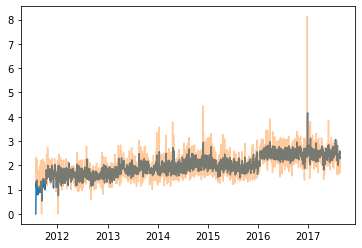

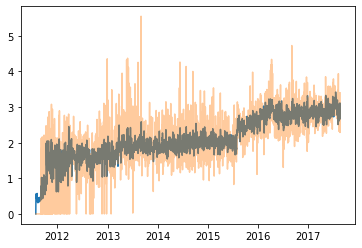

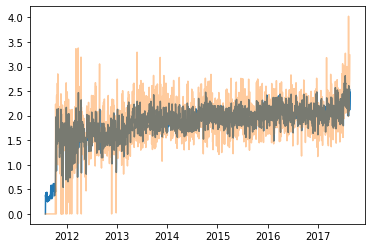

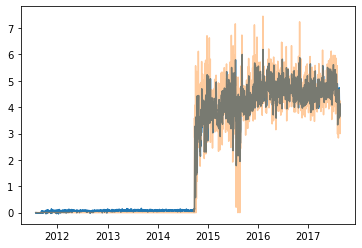

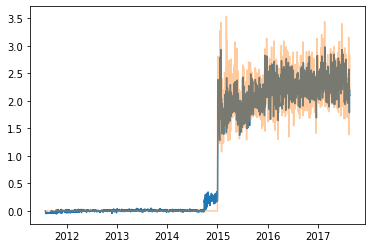

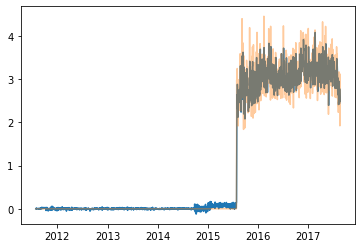

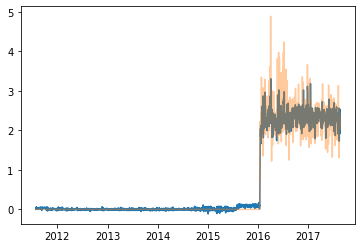

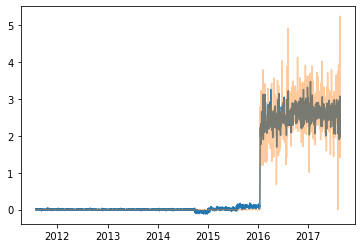

In [612]:
for i in range(8):
    plt.plot(y_pred[f"Label {i}"])
    plt.plot(y_cols[f"Label {i}"], alpha=0.4)
    plt.show()
